In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

 
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection as model_sel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

## OBTENER DATOS

In [3]:
df_diabetes=pd.read_csv("diabetes.csv",encoding="ISO-8859-1",delimiter=",")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## REGRESIÓN LOGÍSTICA

* Pertenece a los modelos de aprendizaje supervisado. 
* Es un modelo lineal para la clasificación en lugar de la regresión.
* La regresión logística es un método estadístico que trata de modelar la probabilidad de una variable cualitativa binaria (dos posibles valores) en función de una o más variables independientes.

**SELECCIONAR CARACTERÍSTICAS**

In [4]:
# Dividir los datos en características (X) y la variable objetivo (y)
X = df_diabetes.drop('Outcome', axis=1)  # Características

y = df_diabetes['Outcome']  # Variable objetivo

**1-DIVIDIR DATOS ENTRENAMIENTO Y TEST**    
    
**2-ESCALAR LOS DATOS**: La estandarización implica transformar las características de     
manera que tengan una media de cero y una desviación estándar de uno.    
    
La fórmula utilizada para lograrlo es la siguiente: 𝑥𝑒𝑠𝑐𝑎𝑙𝑎𝑑𝑜 = 𝑥−𝑚𝑒𝑑𝑖𝑎 / 𝑑𝑒𝑠𝑣𝑖𝑎𝑐𝑖ó𝑛 𝑠𝑡𝑎𝑛𝑑𝑎𝑟𝑑    


In [5]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
#stratify: La idea detrás de la estratificación es mantener la misma proporción de clases en ambos conjuntos, lo que es especialmente relevante cuando se trabaja con conjuntos de datos desequilibrados.
#Shufle: la práctica de presentar los datos al modelo en un orden aleatorio durante la fase de entrenamiento para evitar sesgos y mejorar la generalización y la convergencia del modelo.
#stratify=y,

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ENTRENAMIENTO Y PREDICCIÓN

In [6]:
# Crear y entrenar el modelo de regresión logística
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [7]:
# Información del modelo

print("Intercept:", model.intercept_)

Intercept: [-0.88612313]


In [8]:
#probando como me predice eligiendo algunas filas del df

X2 = df_diabetes.iloc[0:3,0:8].values  # con values lo paso a array como está el de train y test
X2_scaled = scaler.fit_transform(df_diabetes.iloc[0:3, 0:8].values)
X2_pred=model.predict(X2_scaled)

print(X2_pred)
print("\n",X2)

[1 0 0]

 [[  6.    148.     72.     35.      0.     33.6     0.627  50.   ]
 [  1.     85.     66.     29.      0.     26.6     0.351  31.   ]
 [  8.    183.     64.      0.      0.     23.3     0.672  32.   ]]


## **EVALUAR EL MODELO**
* **MATRIZ DE CONFUSIÓN:** es una tabla que se utiliza en problemas de clasificación para evaluar el rendimiento de un modelo de aprendizaje automático. Esta tabla compara las predicciones del modelo con las clases reales de los datos y muestra cuántos de los resultados fueron clasificados correctamente y cuántos fueron clasificados incorrectamente.

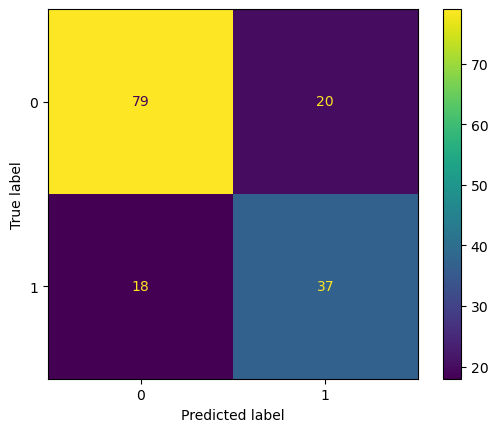

In [9]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

**MÉTRICAS DE EVALUACIÓN**
* **Exactitud (Accuracy):** es la proporción de predicciones correctas (verdaderos positivos y verdaderos negativos) con respecto al total de predicciones realizadas. Es una métrica fácil de entender, pero puede no ser la mejor elección cuando las clases están desequilibradas.
* **Precisión (Precision):** mide la proporción de verdaderos positivos con respecto a todas las predicciones positivas realizadas. Es útil cuando el costo de los falsos positivos es alto y deseas minimizarlos.
 * **Recall (Recuperación o Sensibilidad):** mide la proporción de verdaderos positivos con respecto a todos los casos reales positivos en los datos. Es útil cuando el costo de los falsos negativos es alto y deseas minimizarlos.    
* **F1-Score:** es la media armónica de precisión y recall. Es útil cuando deseas equilibrar la precisión y el recall en tu evaluación. Puede ser especialmente útil en situaciones de clases desequilibradas.   

In [10]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test, y_pred),2))
print("Precisión:", round(precision_score(y_test, y_pred),2))
print("Recall:", round(recall_score(y_test, y_pred),2))
print("F1 score:", round(f1_score(y_test, y_pred),2))

Accuracy del modelo:  0.75
Precisión: 0.65
Recall: 0.67
F1 score: 0.66


In [11]:
classification_rep = classification_report(y_test, y_pred)
print(f"\nReporte de clasificación:\n{classification_rep}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



**ELIMINAREMOS AQUELLOS FILAS DE LOS CAMPOS (Glucose, BMI,BloodPressure) QUE CONTIENEN 0 A FIN DE CORROBORAR SI OBTENEMOS MEJORAS EN LOS RESULTADOS**

In [12]:
df_diabetes_2 = df_diabetes.loc[(df_diabetes["Glucose"] != 0) & (df_diabetes["BMI"] != 0) & (df_diabetes["BloodPressure"] != 0)]
print(df_diabetes_2.shape)

(724, 9)


In [13]:
# Dividir los datos en características (X) y la variable objetivo (y)
X2 = df_diabetes_2.drop('Outcome', axis=1)  # Características

y2 = df_diabetes_2['Outcome']  # Variable objetivo

In [14]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
#stratify: La idea detrás de la estratificación es mantener la misma proporción de clases en ambos conjuntos, lo que es especialmente relevante cuando se trabaja con conjuntos de datos desequilibrados.
#Shufle: la práctica de presentar los datos al modelo en un orden aleatorio durante la fase de entrenamiento para evitar sesgos y mejorar la generalización y la convergencia del modelo.
#stratify=y,

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [15]:
# Crear y entrenar el modelo de regresión logística
model2 = LogisticRegression(random_state=42)
model2.fit(X_train2, y_train2)

# Realizar predicciones en el conjunto de prueba
y_pred2 = model2.predict(X_test2)

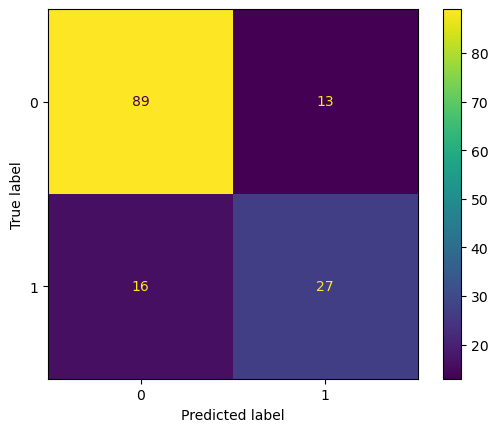

In [16]:
cm2 = confusion_matrix(y_test2, y_pred2)
ConfusionMatrixDisplay(cm2).plot()
plt.show()

In [17]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test2, y_pred2),2))
print("Precisión:", round(precision_score(y_test2, y_pred2),2))
print("Recall:", round(recall_score(y_test2, y_pred2),2))
print("F1 score:", round(f1_score(y_test2, y_pred2),2))

Accuracy del modelo:  0.8
Precisión: 0.68
Recall: 0.63
F1 score: 0.65


In [18]:
classification_rep2 = classification_report(y_test2, y_pred2)
print(f"\nReporte de clasificación:\n{classification_rep2}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       102
           1       0.68      0.63      0.65        43

    accuracy                           0.80       145
   macro avg       0.76      0.75      0.76       145
weighted avg       0.80      0.80      0.80       145



**Primeras conclusiones:**    
* El modelo inicial, con datos estandarizados, obtuvo un accuracy de 0.75. En el reporte de clasificación se verifica mayor precisión en la clase predominante que es la 0. Además, en la clase 1, se verifica un recall bajo. Esta combinación suele ser frecuente en casos de clases desbalanceadas.
* Al eliminar las filas que contenían posibles errores en el registro del dato. Se mejora el accuracy a 0.8, y la precisión a 0.68. De todos modos sigue con mejor precisión en la clase predominante.

**RANDOM OVER SAMPLER:**
* Vamos a crear muestras nuevas “sintéticas” de la clase minoritaria.

In [33]:
# Dividir los datos en características (X) y la variable objetivo (y)
X3 = df_diabetes_2.drop('Outcome', axis=1)  # Características
y3 = df_diabetes_2['Outcome']  # Variable objetivo

In [37]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [51]:
os =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os.fit_resample(X_train3, y_train3)

print ("Distribution before resampling {}".format(Counter(y_train3)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 373, 1: 206})
Distribution labels after resampling Counter({0: 373, 1: 373})


In [52]:
model3 = LogisticRegression(random_state=42)
model3.fit(X_train_res, y_train_res)

# Realizar predicciones en el conjunto de prueba
y_pred3 = model3.predict(X_test3)

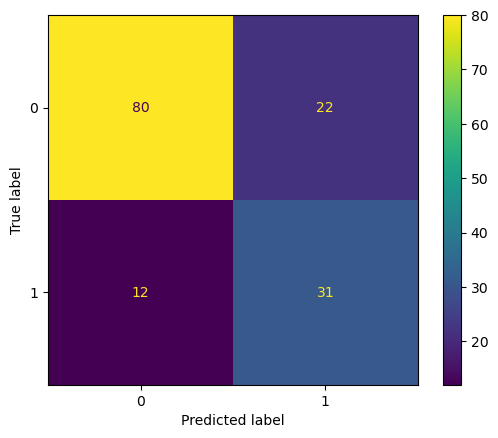

In [53]:
cm3 = confusion_matrix(y_test3, y_pred3)
ConfusionMatrixDisplay(cm3).plot()
plt.show()

In [54]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test3, y_pred3),2))
print("Precisión:", round(precision_score(y_test3, y_pred3),2))
print("Recall:", round(recall_score(y_test3, y_pred3),2))
print("F1 score:", round(f1_score(y_test3, y_pred3),2))

Accuracy del modelo:  0.77
Precisión: 0.58
Recall: 0.72
F1 score: 0.65


In [55]:
classification_rep3 = classification_report(y_test3, y_pred3)
print(f"\nReporte de clasificación:\n{classification_rep3}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       102
           1       0.58      0.72      0.65        43

    accuracy                           0.77       145
   macro avg       0.73      0.75      0.74       145
weighted avg       0.79      0.77      0.77       145



**Nuevas conclusiones:**    
* Al crear muestras sintéticas de la clase minoritaria, se observa que el accuracy del modelo baja. En cuanto a la clase minoritaria, se aprecia que ha mejorado su recall, pero su precisión es menor que con el modelo que no tenía muestras sintéticas.